In [3]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from scipy.stats import gaussian_kde

import psutil
import time
import os 

In [4]:
process = psutil.Process(os.getpid())
print(process.memory_info().rss)


def plot_som(som, data, target=None) :
    plt.figure(figsize=(16, 12))
    bone()
    pcolor(som.distance_map().T)
    colorbar()
    markers = ['o', 's', 'D', '+', 'v', 'p', '*', "x"]
    colors = ['r', 'g', 'b', 'y', 'pink', 'orange', 'purple', "grey"]
    if target is not None:
        for cnt, xx in enumerate(data):
            w = som.winner(xx)
            plot(w[0]+.5,w[1]+.5,markers[target[cnt]], markerfacecolor='None',
            markeredgecolor=colors[target[cnt]], markersize=12, markeredgewidth=2)
        axis([0,som.weights.shape[0],0,som.weights.shape[1]]) #THISS
        show()
    else:
        for cnt, xx in enumerate(data):
            w = som.winner(xx)
            plot(w[0]+.5,w[1]+.5,markers[0],markerfacecolor='None',
            markeredgecolor=colors[0],markersize=12,markeredgewidth=2)
        show()
        

131371008


In [5]:
# Importing the dataset
#df = pd.read_csv('KDDTrain+_20Percent.csv')
df = pd.read_csv('KDDTrain+.csv', header=None)
dft = pd.read_csv('KDDtest.csv', header=None)
full = pd.concat([df, dft])


In [4]:
# The CSV file has no column heads, so add them

full.columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
    'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
    'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
    'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
    'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
    'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate', 'outcome', 'score']


full.outcome=full['outcome'].replace({ 
             'normal' : 0, 
             'neptune' : 3 ,
             'back': 3, #should be 3
             'land': 3, 
             'pod': 3,
             'smurf': 3,  
             'teardrop': 3,
             'mailbomb': 3, 
             'apache2': 3, 
             'processtable': 3, 
             'udpstorm': 3, 
             'worm': 3, 
             'ipsweep' : 1, 
             'nmap' : 1, 
             'portsweep' : 1, 
             'satan' : 1, 
             'mscan' : 1, 
             'saint' : 1, 
             'ftp_write': 2, 
             'guess_passwd': 2, 
             'imap': 2, 
             'multihop': 2,
             'phf': 2,
             'spy': 2,
             'warezclient': 2,
             'warezmaster': 2,
             'sendmail': 2, 
             'named': 2, 
             'snmpgetattack': 2,
             'snmpguess': 2,
             'xlock': 2,
             'xsnoop': 2,
             'httptunnel': 2,
             'buffer_overflow': 4,
             'loadmodule': 4,
             'perl': 4,
             'rootkit': 4,
             'ps': 4,
             'sqlattack': 4,
             'xterm': 4}).astype(int)

del full['score']


In [10]:

# New dataframe with dummy variables for categorical features. Features size from 42 to 120.
full2 = pd.get_dummies(full,drop_first = True)


df=full2[0:df.shape[0]] # NSL-KDD Training dataset that will eventually contain just the training features (take out class later).
dfy=full2['outcome'][0:df.shape[0]] # NSL-KDD Training dataset that just includes the the class labels 
dft=full2[df.shape[0]:] #NSL-KDD Test dataset that includes features and class column that will be seperated later
dfty=full2['outcome'][df.shape[0]:] #NSL-KDD test data that only has class column


In [12]:
target_benign = df[df['outcome'] == 0].iloc[:, 38] #This is only the class series for NSL-KDD training dataset 
target = df['outcome']  #This class series will be used later for feature selection

#
dft_target_benign = dft[dft['outcome'] == 0].iloc[:, 38] # Creates a vector of zeros indicating benign traffic 
dft_target_probe = dft[dft['outcome'] == 1].iloc[:, 38] # Creates a vector of ones for class label
dft_target_r2l = dft[dft['outcome'] == 2].iloc[:, 38] # Creates a vector of twos for class label
dft_target_dos = dft[dft['outcome'] == 3].iloc[:, 38] # Creates a vector of threes for class label
dft_target_u2r = dft[dft['outcome'] == 4].iloc[:, 38] # Creates a vector of fours for class label
dft_target = dft['outcome'] #Just the series of the class column of NSL-KDD test dataset

data_benign = df[df['outcome'] == 0].drop(['outcome'], axis =1) #kddtrain+ features vector 

data = df.drop(['outcome'], axis =1) #The training feature set will be used for feature selection 


dft_data_benign = dft[dft['outcome'] == 0].drop(['outcome'], axis =1) 
dft_data_probe = dft[dft['outcome'] == 1].drop(['outcome'], axis =1) 
dft_data_r2l = dft[dft['outcome'] == 2].drop(['outcome'], axis =1) 
dft_data_dos = dft[dft['outcome'] == 3].drop(['outcome'], axis =1) 
dft_data_u2r = dft[dft['outcome'] == 4].drop(['outcome'], axis =1) 

dft_data = dft.drop(['outcome'], axis =1) #KDDTest datatset independent features 


In [14]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1))

data = sc.fit_transform(data) 

dft_data = sc.fit_transform(dft_data) 
data_benign = sc.fit_transform(data_benign) 
dft_data_benign = sc.fit_transform(dft_data_benign)
dft_data_probe = sc.fit_transform(dft_data_probe) 
dft_data_r2l = sc.fit_transform(dft_data_r2l) 
dft_data_dos = sc.fit_transform(dft_data_dos) 
dft_data_u2r = sc.fit_transform(dft_data_u2r) 

In [26]:
#feature selection aka dimention reduction
clf = ExtraTreesClassifier()
clf.fit(data, target)
sfm = SelectFromModel(clf, prefit=True)

data_benign_new = sfm.transform(data_benign) 
dft_data_benign_new = sfm.transform(dft_data_benign) 
dft_data_probe_new = sfm.transform(dft_data_probe) 
dft_data_r2l_new = sfm.transform(dft_data_r2l) 
dft_data_dos_new = sfm.transform(dft_data_dos) 
dft_data_u2r_new = sfm.transform(dft_data_u2r)
data_new = sfm.transform(data) #this is our feature vectors for KDDtrain+
dft_data_new = sfm.transform(dft_data) #this is features vectors for KDDtest+ aka evaluation



In [16]:
#bayesian optimization aka hyperparameter tuning
from hyperopt import Trials, STATUS_OK, fmin, tpe, hp
import minisom 

# define search space

space = { 'sigma' : hp.uniform('sigma', 5, 10), 
         'learning_rate': hp.uniform('learning_rate', 0.05, 5),
         'x': hp.uniform('x', 20, 50)}

# define an objective function, scoring points in the above space
def som_fn(space):
    sig = space['sigma']
    learning_rate = space['learning_rate']
    x = int(space['x'])
    val = minisom.MiniSom(x=x, y=x, input_len=data_benign_new.shape[1], #generating a loss value
                          sigma=sig, 
                          learning_rate=learning_rate
                          ).quantization_error(data_benign_new[0:100, :])
    print(space)
    print(val)
    return {'loss': val, 'status' : STATUS_OK} #function we want to optimize

trials = Trials()
best = fmin(fn=som_fn,
            space=space,
            algo=tpe.suggest,
            max_evals=1200,
            trials=trials)

print('best: {}'.format(best))

{'learning_rate': 4.196091095955324, 'sigma': 9.694979779379835, 'x': 34.97618770333929}                               
2.142600028649261                                                                                                      
{'learning_rate': 0.5481411507530136, 'sigma': 6.403716026486632, 'x': 49.95796065408332}                              
2.1629530474814778                                                                                                     
{'learning_rate': 3.922373853127948, 'sigma': 8.834261002535344, 'x': 20.94982477445681}                               
2.2321375386501705                                                                                                     
{'learning_rate': 1.4578203383963264, 'sigma': 9.190983502687997, 'x': 20.318506623455523}                             
2.197821164147188                                                                                                      
{'learning_rate': 2.8382165488752857, 's

{'learning_rate': 0.9265581038475663, 'sigma': 5.7922630895473874, 'x': 40.93066507834126}                             
2.136556666235744                                                                                                      
{'learning_rate': 1.7997329763989862, 'sigma': 6.05459306870578, 'x': 42.29435119005636}                               
2.1943524170281066                                                                                                     
{'learning_rate': 1.589572869763873, 'sigma': 5.290602276888994, 'x': 37.60293719255312}                               
2.136026728811242                                                                                                      
{'learning_rate': 2.3017338603934956, 'sigma': 7.298340761632523, 'x': 46.23986196776784}                              
2.189531763248305                                                                                                      
{'learning_rate': 0.7043448590169866, 's

{'learning_rate': 0.8593740172561737, 'sigma': 8.25525712588078, 'x': 42.13481356368291}                               
2.142182775500272                                                                                                      
{'learning_rate': 1.5676912306442514, 'sigma': 6.803611017142935, 'x': 38.183327135719445}                             
2.104785072023711                                                                                                      
{'learning_rate': 0.31361482004716135, 'sigma': 6.973896802015153, 'x': 37.51303532803077}                             
2.192356782936154                                                                                                      
{'learning_rate': 2.0675945668810716, 'sigma': 5.485895277919669, 'x': 39.207198267441655}                             
2.1900622135958594                                                                                                     
{'learning_rate': 1.0699131575201613, 's

{'learning_rate': 2.90614132550996, 'sigma': 7.010465679842002, 'x': 36.75416917327841}                                
2.16850561459664                                                                                                       
{'learning_rate': 0.7097232543491245, 'sigma': 5.011058121166183, 'x': 47.298745259348735}                             
2.182971128228604                                                                                                      
{'learning_rate': 1.0135085183792323, 'sigma': 7.248805545311279, 'x': 45.12363583113592}                              
2.147101431368878                                                                                                      
{'learning_rate': 0.8752484887929937, 'sigma': 7.594304862144965, 'x': 46.35043805398052}                              
2.1547941311255925                                                                                                     
{'learning_rate': 3.322328719617889, 'si

{'learning_rate': 0.2633031397438813, 'sigma': 5.330341642977284, 'x': 46.86494679904878}                              
2.1676885237235166                                                                                                     
{'learning_rate': 1.08037433504072, 'sigma': 5.124078876646802, 'x': 42.92877404534373}                                
2.130270857080977                                                                                                      
{'learning_rate': 1.466424316030961, 'sigma': 9.576288736173606, 'x': 40.3228480104162}                                
2.146447884752736                                                                                                      
{'learning_rate': 0.8783500802996501, 'sigma': 6.233100352329476, 'x': 48.1303736150128}                               
2.1711997475081146                                                                                                     
{'learning_rate': 2.155513691931899, 'si

{'learning_rate': 0.22497990465999407, 'sigma': 9.70767733206737, 'x': 47.20904402564278}                              
2.1400137507547625                                                                                                     
{'learning_rate': 1.2969230909720764, 'sigma': 9.941590099747422, 'x': 46.18948470302249}                              
2.184038556718774                                                                                                      
{'learning_rate': 0.8949139519929497, 'sigma': 9.385537012246624, 'x': 25.28894322400641}                              
2.193079294158262                                                                                                      
{'learning_rate': 0.5407311197796583, 'sigma': 9.474226701041372, 'x': 26.751001241137335}                             
2.2148241285239534                                                                                                     
{'learning_rate': 0.6503557196380889, 's

{'learning_rate': 0.9400097981850661, 'sigma': 9.229959600188451, 'x': 48.04839821005483}                              
2.1813802860352696                                                                                                     
{'learning_rate': 0.056642394439834765, 'sigma': 9.484559125577658, 'x': 41.98504140889048}                            
2.156943946472721                                                                                                      
{'learning_rate': 0.43524175947053906, 'sigma': 8.370725361887082, 'x': 45.92307005309438}                             
2.1490573530778003                                                                                                     
{'learning_rate': 0.6471716396312792, 'sigma': 8.675714564994507, 'x': 42.988873010292075}                             
2.162258905218061                                                                                                      
{'learning_rate': 0.34836154424412086, '

{'learning_rate': 1.4347252222321705, 'sigma': 9.674288128691868, 'x': 35.83236093446115}                              
2.197262754450567                                                                                                      
{'learning_rate': 1.0665550514254378, 'sigma': 7.860103953711047, 'x': 41.09958827316025}                              
2.17005763242603                                                                                                       
{'learning_rate': 2.060846449660797, 'sigma': 9.45410499104832, 'x': 40.26955614650692}                                
2.1686845627028113                                                                                                     
{'learning_rate': 2.264678453664798, 'sigma': 9.255281475725702, 'x': 31.032598691251952}                              
2.161858084720355                                                                                                      
{'learning_rate': 1.7601670332446442, 's

{'learning_rate': 3.019024500766634, 'sigma': 9.764028988299609, 'x': 48.68649156359631}                               
2.130115099908417                                                                                                      
{'learning_rate': 1.191282635468693, 'sigma': 8.624811277906156, 'x': 47.09783113520156}                               
2.171093859135655                                                                                                      
{'learning_rate': 0.6312015526870652, 'sigma': 9.493734719404998, 'x': 46.358663853414726}                             
2.154871775461102                                                                                                      
{'learning_rate': 1.3340973229359643, 'sigma': 8.13353007644542, 'x': 44.3742201675034}                                
2.1721067951502704                                                                                                     
{'learning_rate': 0.2634301473400078, 's

{'learning_rate': 0.38360552595752595, 'sigma': 9.796184798010371, 'x': 43.60429278987334}                             
2.1665242489487344                                                                                                     
{'learning_rate': 0.2511865279095786, 'sigma': 8.573380164777419, 'x': 49.99807426941439}                              
2.166095425260896                                                                                                      
{'learning_rate': 0.6444857760643773, 'sigma': 9.599324608841599, 'x': 42.61701964982158}                              
2.133869728658767                                                                                                      
{'learning_rate': 0.9330569215638718, 'sigma': 9.88046153679464, 'x': 48.47946650375118}                               
2.1720780829259807                                                                                                     
{'learning_rate': 0.5610150407604386, 's

{'learning_rate': 1.5166349458769568, 'sigma': 9.995865840778853, 'x': 47.88908875214615}                              
2.169227336921387                                                                                                      
{'learning_rate': 0.9075291107813277, 'sigma': 8.297539795053849, 'x': 44.411087045206585}                             
2.1602763334576283                                                                                                     
{'learning_rate': 1.1137438315282964, 'sigma': 9.14878912443179, 'x': 49.30777206573269}                               
2.115275440874531                                                                                                      
{'learning_rate': 1.8117028156165005, 'sigma': 8.486488143447636, 'x': 46.633848576149106}                             
2.149197910109952                                                                                                      
{'learning_rate': 0.13911132161635564, '

{'learning_rate': 1.1259083295404022, 'sigma': 8.578441405965997, 'x': 40.813928427624354}                             
2.1757056138637396                                                                                                     
{'learning_rate': 2.659887922638263, 'sigma': 8.706658948074747, 'x': 47.263468826126136}                              
2.1554013971465964                                                                                                     
{'learning_rate': 1.2402028209485885, 'sigma': 9.70068393463267, 'x': 42.03293353836298}                               
2.158600942128548                                                                                                      
{'learning_rate': 1.5349602403126725, 'sigma': 9.149580276366834, 'x': 44.08565232558149}                              
2.166627589599276                                                                                                      
{'learning_rate': 0.9760261853862293, 's

{'learning_rate': 0.5393874886765787, 'sigma': 8.964773396951491, 'x': 23.530384962274802}                             
2.2262799866554386                                                                                                     
{'learning_rate': 1.0747079773394979, 'sigma': 8.719391739484031, 'x': 43.90647201002965}                              
2.1581241891954934                                                                                                     
{'learning_rate': 1.2460899815594824, 'sigma': 9.57680161083174, 'x': 45.24304732618262}                               
2.1051624236182294                                                                                                     
{'learning_rate': 0.8288558596554034, 'sigma': 9.71383791177278, 'x': 46.327233091486406}                              
2.0966591477677308                                                                                                     
{'learning_rate': 0.4036112400555198, 's

{'learning_rate': 1.1015663427308815, 'sigma': 9.564724635711315, 'x': 42.769948217887894}                             
2.154239759558821                                                                                                      
{'learning_rate': 0.44230540431392995, 'sigma': 9.43505288595516, 'x': 46.12916849514333}                              
2.1275990098854454                                                                                                     
{'learning_rate': 0.7117569514284944, 'sigma': 7.928290096783267, 'x': 43.85242763907265}                              
2.1446119240544927                                                                                                     
{'learning_rate': 2.4612864011339783, 'sigma': 8.668646597311879, 'x': 46.96788461032881}                              
2.129036724580848                                                                                                      
{'learning_rate': 1.9624067084320083, 's

{'learning_rate': 0.05182624509153255, 'sigma': 9.396329999535453, 'x': 44.428869089784826}                            
2.171891894196189                                                                                                      
{'learning_rate': 1.576588099148825, 'sigma': 9.262815926222135, 'x': 49.95572417464239}                               
2.15539499513053                                                                                                       
{'learning_rate': 3.940087642485392, 'sigma': 6.088160896513939, 'x': 38.77705865052562}                               
2.2112487752308683                                                                                                     
{'learning_rate': 0.2778860824958087, 'sigma': 8.894619636947075, 'x': 47.642376358721165}                             
2.1572852301160297                                                                                                     
{'learning_rate': 2.896080681466484, 'si

{'learning_rate': 0.05519482466554182, 'sigma': 8.814760009320302, 'x': 46.646971829110846}                            
2.152253202232804                                                                                                      
{'learning_rate': 0.3355431496190605, 'sigma': 9.05429513447022, 'x': 48.949161713998706}                              
2.186801906581028                                                                                                      
{'learning_rate': 0.5177646824387523, 'sigma': 6.157613239927115, 'x': 49.88603455296096}                              
2.1593237732673067                                                                                                     
{'learning_rate': 1.6150956018232785, 'sigma': 8.678713715096526, 'x': 48.17433123360687}                              
2.1757599093895443                                                                                                     
{'learning_rate': 0.6487166100198946, 's

{'learning_rate': 1.5582557779218527, 'sigma': 9.024023260070793, 'x': 44.69107235292861}                              
2.1350823670106256                                                                                                     
{'learning_rate': 0.8827725525225101, 'sigma': 9.91335636616129, 'x': 49.14840858794083}                               
2.1389188796254364                                                                                                     
{'learning_rate': 0.5045600412471247, 'sigma': 9.544672976844101, 'x': 42.52383107557235}                              
2.1589569715248853                                                                                                     
{'learning_rate': 1.727043572896735, 'sigma': 8.901986069710967, 'x': 45.89692294691283}                               
2.077834211082024                                                                                                      
{'learning_rate': 1.782126897561862, 'si

{'learning_rate': 2.1744522121854617, 'sigma': 7.997720318098253, 'x': 43.455478872273844}                             
2.1523756723728864                                                                                                     
{'learning_rate': 1.7139116158466587, 'sigma': 9.217336199448246, 'x': 37.89030858973081}                              
2.2155407475186304                                                                                                     
{'learning_rate': 1.9190099017319788, 'sigma': 8.288123660323278, 'x': 47.05754188620191}                              
2.185204383300204                                                                                                      
{'learning_rate': 1.6203058447109167, 'sigma': 9.134226548064866, 'x': 46.39057068249936}                              
2.137849620375527                                                                                                      
{'learning_rate': 1.8241843510896212, 's

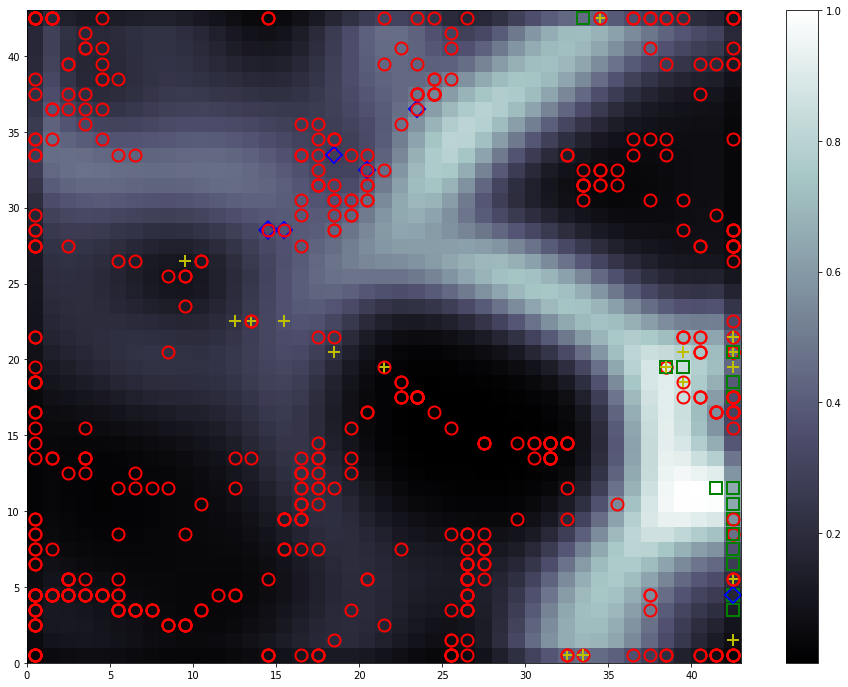

52.819518089294434 seconds


In [21]:
start_timeprint = time.time()


import minisom 
from pylab import bone, pcolor, colorbar, plot, show, axis

som = minisom.MiniSom(x=43, y=43, input_len=data_benign_new.shape[1], 
                      sigma=8.164432071013474, 
                      learning_rate=1.95477168894887272)

som.train_random(data_benign_new, 1000)

n = 1000
plot_som(som, data_new[0:n, :], target[0:n])


elapsed_time = time.time() - start_timeprint
print(elapsed_time, "seconds")

In [20]:


def get_anomalies(benign_metrics, anomaly_metrics, alpha=3, return_outliers=True):
    #gets anomalies from evaluation metric with standard deviation of 3
    
    limit = np.mean(benign_metrics) + np.std(benign_metrics) * alpha
    outliers = np.argwhere(np.abs(anomaly_metrics) > limit)
    print("Determined: ", len(outliers) / len(anomaly_metrics) * 100, "% as anomaly")
    
    if return_outliers:
        return outliers
   
training = data_benign_new # Using KDDtrain+ benign class features for training
#evaluation = data_new # Y Split     
evaluation = dft_data_new # Using the KDDtest+ dataset for evaluating anomaly detector


In [31]:

def minimize_anomaly(benign_metrics, anomaly_metrics, alpha=3):
    #HYPERPARAMETER TUNING
    #objective function to be minimized during tuning calculates 
    #percent error in classifying anomalies based on steady state metrics
    
    limit =  np.mean(benign_metrics) + np.std(benign_metrics) * alpha
    outliers = np.argwhere(np.abs(anomaly_metrics) > limit)
    pct_anomaly = len(outliers) / len(anomaly_metrics)
    return 1 - pct_anomaly

print(minimize_anomaly(benign_metrics, anomaly_metrics))
    
from hyperopt import Trials, STATUS_OK, fmin, tpe, hp
# Hyperparameter Tuning for anomaly detector 
space = {
        'n_neighbors': hp.uniform('n_neighbors', 1, 6),
        'learning_rate': hp.uniform('learning_rate', 0.005, 10),
        'learning_decay': hp.uniform('learning_decay', 0.00001, 0.1),
        'initial_radius': hp.uniform('initial_radius', 1, 10),
        'radius_decay' : hp.uniform('radius_decay', 0.00001, 0.1),
        'x': hp.uniform('x', 10, 50),
        'minNumberPerBmu': hp.uniform('minNumberPerBmu', 0, 10)
        }

def anomaly_fn(space):
    n_neighbors = int(space['n_neighbors'])
    learning_rate = space['learning_rate']
    learning_decay = space['learning_decay']
    initial_radius = int(space['initial_radius'])
    radius_decay = space['radius_decay']
    x = int(space['x'])
    minNumberPerBmu = int(space['minNumberPerBmu'])
    
    anomaly_detector = AnomalyDetection(shape=(x, x),
                                        input_size=training.shape[1],
                                        learning_rate=learning_rate,
                                        learning_decay=learning_decay,
                                        initial_radius=initial_radius,
                                        radius_decay=radius_decay,
                                        minNumberPerBmu=minNumberPerBmu,
                                        numberOfNeighbors=n_neighbors)
    anomaly_detector.fit(training, 5000)
    a_metrics = anomaly_detector.evaluate(evaluation)
    b_metrics = anomaly_detector.evaluate(training)
    val = minimize_anomaly(b_metrics, a_metrics, alpha=3) #generating a value
    
    print(space)
    print(val)
    return {'loss': val, 'status': STATUS_OK}


trials = Trials()
best = fmin(fn=anomaly_fn,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)
print('best: {}'.format(best))

  0%|                                                                            | 0/100 [00:00<?, ?it/s, best loss: ?]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 2.9420585899280947, 'learning_decay': 0.011539949174298365, 'learning_rate': 9.819887538498168, 'minNumberPerBmu': 7.070453742893637, 'n_neighbors': 3.848806041917106, 'radius_decay': 0.06179310192947496, 'x': 41.2788264792772}
0.7114975159687722                                                                                                     
  1%|▍                                                | 1/100 [00:37<1:01:44, 37.42s/it, best loss: 0.7114975159687722]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 9.314103762756941, 'learning_decay': 0.018020249844763997, 'learning_rate': 0.5360778341327002, 'minNumberPerBmu': 8.16797493398821, 'n_neighbors': 3.998296635628004, 'radius_decay': 0.02388268868642545, 'x': 24.195583001546083}
0.7266234918381831                                                                                                     
  2%|█                                                  | 2/100 [00:49<48:34, 29.74s/it, best loss: 0.7114975159687722]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 6.368484825540816, 'learning_decay': 0.04977053258213053, 'learning_rate': 4.794927135229965, 'minNumberPerBmu': 0.8806079086659091, 'n_neighbors': 1.1336367037927184, 'radius_decay': 0.0796038205046227, 'x': 43.32724944375588}
0.7434350603264727                                                                                                     
  3%|█▍                                               | 3/100 [01:47<1:02:01, 38.37s/it, best loss: 0.7114975159687722]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 5.784299512094988, 'learning_decay': 0.00440450402630205, 'learning_rate': 2.5298276329427756, 'minNumberPerBmu': 2.6558378412706, 'n_neighbors': 2.1862589245403625, 'radius_decay': 0.08525507923314096, 'x': 41.07556977772312}
0.7159776437189496                                                                                                     
  4%|█▉                                               | 4/100 [02:36<1:06:33, 41.60s/it, best loss: 0.7114975159687722]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 5.511343928880845, 'learning_decay': 0.06554644677048567, 'learning_rate': 7.176621740716071, 'minNumberPerBmu': 6.134248618433004, 'n_neighbors': 3.89607197719781, 'radius_decay': 0.05488931591139228, 'x': 13.70271058180844}
0.714292051100071                                                                                                      
  5%|██▌                                                | 5/100 [02:41<48:16, 30.49s/it, best loss: 0.7114975159687722]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 2.338607829469563, 'learning_decay': 0.04303022842188046, 'learning_rate': 2.3889491973964314, 'minNumberPerBmu': 3.438675423084442, 'n_neighbors': 2.3361196967689617, 'radius_decay': 0.07795719429500433, 'x': 11.406521922070247}
0.7203690560681335                                                                                                     
  6%|███                                                | 6/100 [02:46<35:56, 22.94s/it, best loss: 0.7114975159687722]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 1.1826377168736335, 'learning_decay': 0.012403088827988478, 'learning_rate': 4.032673938149231, 'minNumberPerBmu': 7.266196936590577, 'n_neighbors': 1.3607702128665424, 'radius_decay': 0.01665678841938376, 'x': 12.246649167807874}
0.6671841731724628                                                                                                     
  7%|███▌                                               | 7/100 [02:52<27:31, 17.75s/it, best loss: 0.6671841731724628]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 2.449425597334096, 'learning_decay': 0.0989808395116551, 'learning_rate': 7.944141980416302, 'minNumberPerBmu': 1.3114473611952115, 'n_neighbors': 5.545190356653979, 'radius_decay': 0.08111732989457783, 'x': 23.13057018263862}
0.8814318665720369                                                                                                     
  8%|████                                               | 8/100 [03:04<24:29, 15.97s/it, best loss: 0.6671841731724628]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 7.795374153558027, 'learning_decay': 0.07876322260667086, 'learning_rate': 4.57239654607964, 'minNumberPerBmu': 0.9681776132652764, 'n_neighbors': 3.5600988020359825, 'radius_decay': 0.09833660132949892, 'x': 39.200977311237814}
0.7249378992193045                                                                                                     
  9%|████▌                                              | 9/100 [03:57<41:21, 27.27s/it, best loss: 0.6671841731724628]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 5.585827214522167, 'learning_decay': 0.07122516279514497, 'learning_rate': 9.317217648997717, 'minNumberPerBmu': 3.7950920015664513, 'n_neighbors': 3.972484391440731, 'radius_decay': 0.013009244520356962, 'x': 19.352697822391484}
0.7570528743789922                                                                                                     
 10%|█████                                             | 10/100 [04:07<33:10, 22.11s/it, best loss: 0.6671841731724628]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 4.785563462859958, 'learning_decay': 0.0788829604293269, 'learning_rate': 0.5515698956761611, 'minNumberPerBmu': 8.472708529806873, 'n_neighbors': 3.4268534761871003, 'radius_decay': 0.028619908155258195, 'x': 34.932621106332675}
0.7205464868701206                                                                                                     
 11%|█████▌                                            | 11/100 [04:50<41:48, 28.19s/it, best loss: 0.6671841731724628]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 8.068265850023877, 'learning_decay': 0.057134610485914325, 'learning_rate': 3.285358606987477, 'minNumberPerBmu': 5.7082793482043925, 'n_neighbors': 1.6783640085700204, 'radius_decay': 0.055414847079022125, 'x': 19.887226917715005}
0.7609563520227112                                                                                                     
 12%|██████                                            | 12/100 [05:01<33:57, 23.15s/it, best loss: 0.6671841731724628]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 6.930238577727339, 'learning_decay': 0.05232270441231917, 'learning_rate': 7.392802777894945, 'minNumberPerBmu': 5.923261268758973, 'n_neighbors': 2.5083300446389183, 'radius_decay': 0.02027209320893355, 'x': 17.993542566303717}
0.6976579134137686                                                                                                     
 13%|██████▌                                           | 13/100 [05:12<28:16, 19.50s/it, best loss: 0.6671841731724628]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 5.48044307723371, 'learning_decay': 0.055486775630020725, 'learning_rate': 7.997034718693537, 'minNumberPerBmu': 5.893329496053148, 'n_neighbors': 5.986627600154035, 'radius_decay': 0.0019092257862279886, 'x': 46.03071448651968}
0.7334545777146912                                                                                                     
 14%|███████                                           | 14/100 [06:18<47:42, 33.28s/it, best loss: 0.6671841731724628]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 6.186367748037526, 'learning_decay': 0.030010113244825845, 'learning_rate': 4.774535432466291, 'minNumberPerBmu': 2.7839080076703135, 'n_neighbors': 4.5878621096850445, 'radius_decay': 0.09005988185366273, 'x': 38.011320476363736}
0.7224538679914834                                                                                                     
 15%|███████▌                                          | 15/100 [07:05<53:03, 37.45s/it, best loss: 0.6671841731724628]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 9.759629987565887, 'learning_decay': 0.060112923383814125, 'learning_rate': 6.652050984574576, 'minNumberPerBmu': 0.3059148652263022, 'n_neighbors': 1.811055272760624, 'radius_decay': 0.03857955365391757, 'x': 35.88798810180498}
0.6354240596167495                                                                                                     
 16%|████████                                          | 16/100 [07:51<55:59, 40.00s/it, best loss: 0.6354240596167495]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 3.362242776127416, 'learning_decay': 0.05869752659342406, 'learning_rate': 6.6147308983149005, 'minNumberPerBmu': 7.651142074301331, 'n_neighbors': 1.6352831054877432, 'radius_decay': 0.058497986639267974, 'x': 34.61809164881655}
0.6424769339957417                                                                                                     
 17%|████████▌                                         | 17/100 [08:19<50:25, 36.45s/it, best loss: 0.6354240596167495]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 8.632692143468983, 'learning_decay': 0.0795927264793912, 'learning_rate': 2.447272982917927, 'minNumberPerBmu': 4.561554026094074, 'n_neighbors': 3.0496245606136743, 'radius_decay': 0.037521433640284874, 'x': 27.965466992698943}
0.9135468417317246                                                                                                     
 18%|█████████                                         | 18/100 [08:33<40:34, 29.69s/it, best loss: 0.6354240596167495]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 6.503279517428873, 'learning_decay': 0.07702612658862804, 'learning_rate': 4.015814006116732, 'minNumberPerBmu': 8.481391087522006, 'n_neighbors': 5.6112927597773625, 'radius_decay': 0.08634436990783087, 'x': 40.72485406962497}
0.9941447835344216                                                                                                     
 19%|█████████▌                                        | 19/100 [09:11<43:27, 32.20s/it, best loss: 0.6354240596167495]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 7.06409314365923, 'learning_decay': 0.03738739038787223, 'learning_rate': 1.720533552427692, 'minNumberPerBmu': 4.272077674420438, 'n_neighbors': 5.488733453701101, 'radius_decay': 0.04676822652680781, 'x': 49.620518634956674}
0.7024929027679205                                                                                                     
 20%|██████████                                        | 20/100 [10:05<51:39, 38.75s/it, best loss: 0.6354240596167495]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 3.9644241030435796, 'learning_decay': 0.09230838364852335, 'learning_rate': 6.295445298406369, 'minNumberPerBmu': 9.17866795608287, 'n_neighbors': 1.7764196149244438, 'radius_decay': 0.06669036801800235, 'x': 33.23763599099758}
0.7610894251242015                                                                                                     
 21%|██████████▌                                       | 21/100 [10:31<46:02, 34.97s/it, best loss: 0.6354240596167495]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 9.843793560479634, 'learning_decay': 0.0652637076946376, 'learning_rate': 5.886053324454955, 'minNumberPerBmu': 9.79585182157006, 'n_neighbors': 2.775954843754283, 'radius_decay': 0.040939831791329456, 'x': 29.852968042903772}
0.7232523066004258                                                                                                     
 22%|███████████                                       | 22/100 [10:47<37:57, 29.20s/it, best loss: 0.6354240596167495]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 1.035931932008162, 'learning_decay': 0.0302525696818294, 'learning_rate': 6.015525013633086, 'minNumberPerBmu': 0.02534524394913562, 'n_neighbors': 1.6755358741351576, 'radius_decay': 0.06925894041337852, 'x': 34.07641066523843}
0.6613289567068843                                                                                                     
 23%|███████████▌                                      | 23/100 [11:18<38:25, 29.94s/it, best loss: 0.6354240596167495]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 4.485213148367988, 'learning_decay': 0.061429841085440216, 'learning_rate': 8.469707706714463, 'minNumberPerBmu': 7.415271754291845, 'n_neighbors': 1.1104711603080037, 'radius_decay': 0.03323890013046375, 'x': 49.66747336671922}
0.7260468417317246                                                                                                                                                                                                
 24%|█████████████████████████████████▊                                                                                                           | 24/100 [12:14<47:32, 37.53s/it, best loss: 0.6354240596167495]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 3.428753903720852, 'learning_decay': 0.0904040816070202, 'learning_rate': 6.652583614248053, 'minNumberPerBmu': 1.875485836089306, 'n_neighbors': 2.0168728344353104, 'radius_decay': 0.046750771822067654, 'x': 36.014485179741136}
0.7164212207239177                                                                                                     
 25%|████████████▌                                     | 25/100 [12:44<44:18, 35.45s/it, best loss: 0.6354240596167495]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 3.635184306521399, 'learning_decay': 0.04503952597889162, 'learning_rate': 8.940934681337895, 'minNumberPerBmu': 9.295928098822229, 'n_neighbors': 2.839723416625705, 'radius_decay': 0.01054370287779384, 'x': 31.515861354831124}
0.7546132008516678                                                                                                     
 26%|█████████████                                     | 26/100 [13:00<36:27, 29.56s/it, best loss: 0.6354240596167495]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 1.9951768316874836, 'learning_decay': 0.036490532924721375, 'learning_rate': 5.230904897067117, 'minNumberPerBmu': 6.58353132500059, 'n_neighbors': 1.3881581644314118, 'radius_decay': 0.055314436811651005, 'x': 28.156651796096423}
0.7529719659332861                                                                                                     
 27%|█████████████▌                                    | 27/100 [13:15<30:26, 25.02s/it, best loss: 0.6354240596167495]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 1.6327722642263753, 'learning_decay': 0.07212760149659908, 'learning_rate': 9.987903878901427, 'minNumberPerBmu': 7.950254699452142, 'n_neighbors': 4.5169549043007375, 'radius_decay': 0.0718191920155175, 'x': 25.109888026135614}
0.7146912704045423                                                                                                     
 28%|██████████████                                    | 28/100 [13:27<25:23, 21.16s/it, best loss: 0.6354240596167495]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 2.7653635739281293, 'learning_decay': 0.0869505334631235, 'learning_rate': 7.113312208789844, 'minNumberPerBmu': 5.287802424412979, 'n_neighbors': 3.239199738142505, 'radius_decay': 0.06197859239625002, 'x': 47.141501760142155}
0.8950496806245565                                                                                                     
 29%|██████████████▍                                   | 29/100 [14:20<36:33, 30.90s/it, best loss: 0.6354240596167495]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 4.70402144133983, 'learning_decay': 0.023805885250164173, 'learning_rate': 5.585959847365109, 'minNumberPerBmu': 0.2425595932085231, 'n_neighbors': 2.587226318449842, 'radius_decay': 0.040683305461439195, 'x': 36.26663123170723}
0.6977022711142654                                                                                                     
 30%|███████████████                                   | 30/100 [14:58<38:29, 32.99s/it, best loss: 0.6354240596167495]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 3.060542990647192, 'learning_decay': 0.06113385509331538, 'learning_rate': 6.603443246953954, 'minNumberPerBmu': 6.755748628147257, 'n_neighbors': 1.9623117424696206, 'radius_decay': 0.0008377635871103795, 'x': 43.39441445605728}
0.7182398864442867                                                                                                     
 31%|███████████████▌                                  | 31/100 [15:41<41:12, 35.84s/it, best loss: 0.6354240596167495]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 9.886042885016195, 'learning_decay': 0.0458665272388819, 'learning_rate': 9.200490211693454, 'minNumberPerBmu': 9.944874704051001, 'n_neighbors': 1.069841610041471, 'radius_decay': 0.060606590243921746, 'x': 43.958119935521836}
0.8142743080198722                                                                                                     
 32%|████████████████                                  | 32/100 [16:24<43:05, 38.03s/it, best loss: 0.6354240596167495]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 8.858194818806876, 'learning_decay': 0.05033728988942654, 'learning_rate': 8.119498159969737, 'minNumberPerBmu': 5.020641500335142, 'n_neighbors': 1.411043877080817, 'radius_decay': 0.0313112696632855, 'x': 32.3738526005614}
0.6462473385379701                                                                                                     
 33%|████████████████▌                                 | 33/100 [16:48<37:43, 33.78s/it, best loss: 0.6354240596167495]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 3.8716569810496546, 'learning_decay': 0.002881410072492374, 'learning_rate': 7.419787226895269, 'minNumberPerBmu': 7.754501441513685, 'n_neighbors': 4.499677588981735, 'radius_decay': 0.025323038181345597, 'x': 25.959530214265975}
0.6359119943222143                                                                                                     
 34%|█████████████████                                 | 34/100 [16:59<29:52, 27.16s/it, best loss: 0.6354240596167495]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 5.072082737025729, 'learning_decay': 0.010792320580610134, 'learning_rate': 9.99607515305722, 'minNumberPerBmu': 2.43620700479179, 'n_neighbors': 4.4551725550460946, 'radius_decay': 0.024682402365483958, 'x': 22.84086209753146}
0.6886976579134138                                                                                                     
 35%|█████████████████▌                                | 35/100 [17:09<23:48, 21.97s/it, best loss: 0.6354240596167495]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 7.574465380727405, 'learning_decay': 0.0015558071956693288, 'learning_rate': 7.43202641323446, 'minNumberPerBmu': 3.331648100838919, 'n_neighbors': 4.879658165468475, 'radius_decay': 0.005315000137628444, 'x': 25.62649243910565}
0.6360894251242015                                                                                                     
 36%|██████████████████                                | 36/100 [17:20<19:44, 18.50s/it, best loss: 0.6354240596167495]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 4.272462961084835, 'learning_decay': 0.02155577119196668, 'learning_rate': 5.281141731546156, 'minNumberPerBmu': 8.860317775903123, 'n_neighbors': 4.883095049873404, 'radius_decay': 0.025167084841515277, 'x': 29.236274688624928}
0.6770315826827538                                                                                                     
 37%|██████████████████▌                               | 37/100 [17:33<17:53, 17.04s/it, best loss: 0.6354240596167495]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 9.241891505765158, 'learning_decay': 0.00860803992153777, 'learning_rate': 4.105326749023933, 'minNumberPerBmu': 6.614050841359861, 'n_neighbors': 4.171283532759148, 'radius_decay': 0.017138469608437276, 'x': 16.853847032303104}
0.6852377572746629                                                                                                     
 38%|███████████████████                               | 38/100 [17:39<14:13, 13.76s/it, best loss: 0.6354240596167495]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 1.6991192074409724, 'learning_decay': 0.03782629402132415, 'learning_rate': 8.816576188302092, 'minNumberPerBmu': 0.6746957856179872, 'n_neighbors': 3.6911020597496806, 'radius_decay': 0.049412378728535565, 'x': 21.770174061130398}
0.6827980837473385                                                                                                     
 39%|███████████████████▌                              | 39/100 [17:50<13:02, 12.82s/it, best loss: 0.6354240596167495]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 5.143442062986154, 'learning_decay': 0.017199296804841117, 'learning_rate': 3.446084460588479, 'minNumberPerBmu': 2.0410749576242937, 'n_neighbors': 4.155670990180232, 'radius_decay': 0.00781434680662801, 'x': 26.80811226023614}
0.6494410929737402                                                                                                     
 40%|████████████████████                              | 40/100 [18:01<12:19, 12.33s/it, best loss: 0.6354240596167495]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 3.8778640555641335, 'learning_decay': 0.09794712273197034, 'learning_rate': 7.679641017832301, 'minNumberPerBmu': 4.359293939874471, 'n_neighbors': 5.184937575073981, 'radius_decay': 0.03609324455848256, 'x': 14.656975411612084}
0.8351224272533712                                                                                                     
 41%|████████████████████▌                             | 41/100 [18:06<10:02, 10.21s/it, best loss: 0.6354240596167495]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 6.067455144188099, 'learning_decay': 0.06899726270788857, 'learning_rate': 8.5407904521574, 'minNumberPerBmu': 5.36222197851731, 'n_neighbors': 3.781755647223757, 'radius_decay': 0.019532029292055192, 'x': 31.351835139176252}
0.7166873669268985                                                                                                     
 42%|█████████████████████                             | 42/100 [18:22<11:28, 11.86s/it, best loss: 0.6354240596167495]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 2.4370417755460574, 'learning_decay': 0.0842147176037491, 'learning_rate': 1.5514578547823312, 'minNumberPerBmu': 1.3758004512513282, 'n_neighbors': 3.255993219637828, 'radius_decay': 0.04421305952832234, 'x': 39.04393260036511}
0.7207682753726047                                                                                                     
 43%|█████████████████████▌                            | 43/100 [18:52<16:29, 17.35s/it, best loss: 0.6354240596167495]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 6.826806413327025, 'learning_decay': 0.00028688715965560167, 'learning_rate': 7.076810682530457, 'minNumberPerBmu': 3.3906856179512417, 'n_neighbors': 5.051342539931224, 'radius_decay': 0.028355252942619792, 'x': 10.207800673613018}
0.696415897799858                                                                                                      
 44%|██████████████████████                            | 44/100 [18:57<12:42, 13.61s/it, best loss: 0.6354240596167495]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 8.185934511868743, 'learning_decay': 0.041489428087591096, 'learning_rate': 4.5676062413070735, 'minNumberPerBmu': 6.293952029417671, 'n_neighbors': 2.334239260832131, 'radius_decay': 0.052444367093573356, 'x': 21.850963712688138}
0.677874378992193                                                                                                      
 45%|██████████████████████▌                           | 45/100 [19:06<11:00, 12.02s/it, best loss: 0.6354240596167495]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 7.411603273556376, 'learning_decay': 0.0663649122383965, 'learning_rate': 9.73968642603665, 'minNumberPerBmu': 3.8255114143567175, 'n_neighbors': 5.917932964161883, 'radius_decay': 0.013061104233941176, 'x': 16.01983191531111}
0.7004524485450674                                                                                                     
 46%|███████████████████████                           | 46/100 [19:12<09:21, 10.40s/it, best loss: 0.6354240596167495]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 2.843521947014748, 'learning_decay': 0.03217530298625615, 'learning_rate': 9.525625603924698, 'minNumberPerBmu': 7.900430371267292, 'n_neighbors': 5.323564451715215, 'radius_decay': 0.09709023755506441, 'x': 41.69812916636426}
0.7741305890702626                                                                                                     
 47%|███████████████████████▌                          | 47/100 [19:46<15:22, 17.40s/it, best loss: 0.6354240596167495]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 5.621192650831293, 'learning_decay': 0.05198190408467085, 'learning_rate': 5.666730272076147, 'minNumberPerBmu': 8.322956510295143, 'n_neighbors': 3.495376610955301, 'radius_decay': 0.07605135132591584, 'x': 19.557511956962728}
0.8531316536550745                                                                                                     
 48%|████████████████████████                          | 48/100 [19:54<12:43, 14.68s/it, best loss: 0.6354240596167495]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 9.498563671235088, 'learning_decay': 0.02643694192424689, 'learning_rate': 8.21553191561727, 'minNumberPerBmu': 7.035291906966838, 'n_neighbors': 5.825985896263234, 'radius_decay': 0.022136482076763563, 'x': 36.67373812566007}
0.6851046841731725                                                                                                     
 49%|████████████████████████▌                         | 49/100 [20:23<16:00, 18.83s/it, best loss: 0.6354240596167495]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 4.202726115584696, 'learning_decay': 0.07401402567025583, 'learning_rate': 3.0043118799448627, 'minNumberPerBmu': 8.84582089900691, 'n_neighbors': 4.711810253707842, 'radius_decay': 0.03579307973496665, 'x': 46.72690524914912}
0.6847941802696949                                                                                                     
 50%|█████████████████████████                         | 50/100 [21:14<23:40, 28.42s/it, best loss: 0.6354240596167495]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 5.898646022623611, 'learning_decay': 0.016547445836045935, 'learning_rate': 0.1442238682456125, 'minNumberPerBmu': 7.0929035450487685, 'n_neighbors': 4.21528985250168, 'radius_decay': 0.027210180400111156, 'x': 37.57881426890188}
0.7967530163236338                                                                                                     
 51%|█████████████████████████▌                        | 51/100 [21:48<24:39, 30.19s/it, best loss: 0.6354240596167495]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 5.248157755158405, 'learning_decay': 0.006812780502835996, 'learning_rate': 7.686667707942395, 'minNumberPerBmu': 4.783442856030665, 'n_neighbors': 3.016876404656129, 'radius_decay': 0.04093431715541547, 'x': 12.647473838900243}
0.6772533711852378                                                                                                     
 52%|██████████████████████████                        | 52/100 [21:53<18:11, 22.74s/it, best loss: 0.6354240596167495]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 6.431258106065372, 'learning_decay': 0.056070076240405914, 'learning_rate': 6.735684881728837, 'minNumberPerBmu': 2.9878181876218073, 'n_neighbors': 3.997928581280343, 'radius_decay': 0.015660035348962133, 'x': 26.586459301621115}
0.705331795599716                                                                                                      
 53%|██████████████████████████▌                       | 53/100 [22:06<15:23, 19.66s/it, best loss: 0.6354240596167495]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 1.4182623187857302, 'learning_decay': 0.04800866980536012, 'learning_rate': 6.041721243212475, 'minNumberPerBmu': 9.70632769150443, 'n_neighbors': 4.323325751577755, 'radius_decay': 0.06390256974377392, 'x': 23.85213119780701}
0.8953158268275373                                                                                                     
 54%|███████████████████████████                       | 54/100 [22:17<13:06, 17.10s/it, best loss: 0.6354240596167495]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 8.18354331125662, 'learning_decay': 0.08329247754484125, 'learning_rate': 4.538091615912183, 'minNumberPerBmu': 5.784277623586963, 'n_neighbors': 2.1159824163609535, 'radius_decay': 0.030728538592304483, 'x': 40.88679353931219}
0.950541163946061                                                                                                      
 55%|███████████████████████████▌                      | 55/100 [23:00<18:41, 24.91s/it, best loss: 0.6354240596167495]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 2.1099981198072175, 'learning_decay': 0.014019880393616839, 'learning_rate': 6.307529882625387, 'minNumberPerBmu': 4.049734879735165, 'n_neighbors': 2.4345598073222092, 'radius_decay': 0.00462041169389487, 'x': 30.741594251363903}
0.6448278921220724                                                                                                     
 56%|████████████████████████████                      | 56/100 [23:18<16:40, 22.75s/it, best loss: 0.6354240596167495]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 3.1403644990074158, 'learning_decay': 0.09368232386443805, 'learning_rate': 5.1417587219619305, 'minNumberPerBmu': 0.6336753179557151, 'n_neighbors': 5.721044718582407, 'radius_decay': 0.048704656772143175, 'x': 33.91134199015761}
0.9094659332860184                                                                                                     
 57%|████████████████████████████▍                     | 57/100 [23:56<19:34, 27.31s/it, best loss: 0.6354240596167495]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 4.7940679423338395, 'learning_decay': 0.06308030823291194, 'learning_rate': 3.9208861840869296, 'minNumberPerBmu': 7.629256294614013, 'n_neighbors': 2.704120941978843, 'radius_decay': 0.04382793842773307, 'x': 28.69794946652045}
0.6862136266855926                                                                                                     
 58%|████████████████████████████▉                     | 58/100 [24:12<16:48, 24.01s/it, best loss: 0.6354240596167495]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 3.5668016330765155, 'learning_decay': 0.05399915066065856, 'learning_rate': 1.300756118062869, 'minNumberPerBmu': 5.492979358223416, 'n_neighbors': 3.336069892164077, 'radius_decay': 0.05353345794669631, 'x': 45.11191516054184}
0.7359386089425124                                                                                                     
 59%|█████████████████████████████▌                    | 59/100 [25:05<22:25, 32.82s/it, best loss: 0.6354240596167495]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 6.678756888180283, 'learning_decay': 0.04104511115213901, 'learning_rate': 6.997317574248553, 'minNumberPerBmu': 9.384216534317686, 'n_neighbors': 3.707749162556371, 'radius_decay': 0.05846647720334098, 'x': 39.803811829873965}
0.7645493257629524                                                                                                     
 60%|██████████████████████████████                    | 60/100 [25:46<23:26, 35.15s/it, best loss: 0.6354240596167495]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 7.061706843079588, 'learning_decay': 0.0334232757754328, 'learning_rate': 9.03945644895497, 'minNumberPerBmu': 1.4240625517137289, 'n_neighbors': 2.98025851284109, 'radius_decay': 0.03435767009208717, 'x': 47.80321553366842}
0.7282203690560681                                                                                                     
 61%|██████████████████████████████▌                   | 61/100 [26:43<27:11, 41.82s/it, best loss: 0.6354240596167495]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 4.036503163329502, 'learning_decay': 0.07565750330720142, 'learning_rate': 7.671394829923936, 'minNumberPerBmu': 6.257803577861475, 'n_neighbors': 4.690361644961404, 'radius_decay': 0.03882318875609283, 'x': 41.94438445158169}
0.6206973030518098                                                                                                     
 62%|███████████████████████████████                   | 62/100 [27:21<25:41, 40.57s/it, best loss: 0.6206973030518098]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 8.795168542431453, 'learning_decay': 0.09720308435711544, 'learning_rate': 8.48495859352461, 'minNumberPerBmu': 6.210722793028316, 'n_neighbors': 5.332292894426623, 'radius_decay': 0.07474451023360242, 'x': 49.994380531591226}
0.731680269694819                                                                                                      
 63%|███████████████████████████████▌                  | 63/100 [28:09<26:25, 42.86s/it, best loss: 0.6206973030518098]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 7.292368283272696, 'learning_decay': 0.07783302996661208, 'learning_rate': 9.463583624204873, 'minNumberPerBmu': 2.3608621741594344, 'n_neighbors': 1.2520746297823777, 'radius_decay': 0.0835561440088301, 'x': 42.135480271094096}
0.7260911994322214                                                                                                     
 64%|████████████████████████████████                  | 64/100 [28:46<24:38, 41.08s/it, best loss: 0.6206973030518098]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 1.012467347137239, 'learning_decay': 0.06797361175892096, 'learning_rate': 7.763834087208651, 'minNumberPerBmu': 5.059611371459742, 'n_neighbors': 1.8026453144008905, 'radius_decay': 0.09282982615197197, 'x': 48.29193288713311}
0.7032469836763662                                                                                                     
 65%|████████████████████████████████▌                 | 65/100 [29:32<24:46, 42.47s/it, best loss: 0.6206973030518098]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 4.536202607672015, 'learning_decay': 0.07502381865878452, 'learning_rate': 6.884629044379191, 'minNumberPerBmu': 8.733523020581314, 'n_neighbors': 4.79497229679462, 'radius_decay': 0.03807845595588023, 'x': 44.79982267850196}
0.926055713271824                                                                                                      
 66%|█████████████████████████████████                 | 66/100 [30:11<23:26, 41.36s/it, best loss: 0.6206973030518098]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 4.895135076743246, 'learning_decay': 0.059384253608546725, 'learning_rate': 7.436094570930987, 'minNumberPerBmu': 7.452569824668817, 'n_neighbors': 5.049814624641883, 'radius_decay': 0.030906939788929503, 'x': 35.210967940423785}
0.7224982256919801                                                                                                     
 67%|█████████████████████████████████▌                | 67/100 [30:38<20:28, 37.23s/it, best loss: 0.6206973030518098]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 2.692709100717979, 'learning_decay': 0.0723597880726908, 'learning_rate': 6.315293697091831, 'minNumberPerBmu': 7.981627135654739, 'n_neighbors': 4.618800394650092, 'radius_decay': 0.04432812617436553, 'x': 32.867669127899525}
0.7127838892831795                                                                                                     
 68%|██████████████████████████████████                | 68/100 [31:00<17:19, 32.50s/it, best loss: 0.6206973030518098]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 3.9585983424594913, 'learning_decay': 0.08313566446379933, 'learning_rate': 5.675816888637213, 'minNumberPerBmu': 6.852536417203208, 'n_neighbors': 4.382349985962867, 'radius_decay': 0.020457306575745186, 'x': 38.61221993844021}
0.8735805535841021                                                                                                     
 69%|██████████████████████████████████▌               | 69/100 [31:30<16:29, 31.91s/it, best loss: 0.6206973030518098]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 5.369674841033751, 'learning_decay': 0.08640975537920013, 'learning_rate': 8.294529702102258, 'minNumberPerBmu': 6.073619158236105, 'n_neighbors': 5.443403566756702, 'radius_decay': 0.03918005304431763, 'x': 42.44763069951262}
0.9945883605393896                                                                                                     
 70%|███████████████████████████████████               | 70/100 [32:06<16:30, 33.02s/it, best loss: 0.6206973030518098]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 3.3436081542694542, 'learning_decay': 0.09006870108238467, 'learning_rate': 8.650045394570107, 'minNumberPerBmu': 6.47596220292945, 'n_neighbors': 3.588597384893724, 'radius_decay': 0.051539461342560246, 'x': 37.41740874654024}
0.8311745919091554                                                                                                     
 71%|███████████████████████████████████▌              | 71/100 [32:35<15:27, 31.97s/it, best loss: 0.6206973030518098]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 4.276952265433864, 'learning_decay': 0.0812066568776185, 'learning_rate': 7.419457803198741, 'minNumberPerBmu': 5.674530038238986, 'n_neighbors': 3.839510196368062, 'radius_decay': 0.009480738591642678, 'x': 40.10205949920591}
0.6984563520227112                                                                                                     
 72%|████████████████████████████████████              | 72/100 [33:07<14:52, 31.89s/it, best loss: 0.6206973030518098]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 3.7279661791587473, 'learning_decay': 0.06380091107022685, 'learning_rate': 4.817588024570244, 'minNumberPerBmu': 7.184225478180627, 'n_neighbors': 4.081215737691111, 'radius_decay': 0.02454355222770909, 'x': 27.133023161186358}
0.71930447125621                                                                                                       
 73%|████████████████████████████████████▌             | 73/100 [33:19<11:36, 25.81s/it, best loss: 0.6206973030518098]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 2.203243719450951, 'learning_decay': 0.04840668830042163, 'learning_rate': 7.914326067209254, 'minNumberPerBmu': 8.465787844174729, 'n_neighbors': 5.066981642991316, 'radius_decay': 0.05822485649261952, 'x': 25.48941074437436}
0.6950408090844571                                                                                                     
 74%|█████████████████████████████████████             | 74/100 [33:30<09:15, 21.38s/it, best loss: 0.6206973030518098]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 2.6481277483257637, 'learning_decay': 0.07022293294576935, 'learning_rate': 5.457358507947448, 'minNumberPerBmu': 4.679480097234061, 'n_neighbors': 3.9359604597268527, 'radius_decay': 0.013154427144105673, 'x': 29.981572014978482}
0.714957416607523                                                                                                      
 75%|█████████████████████████████████████▌            | 75/100 [33:43<07:51, 18.84s/it, best loss: 0.6206973030518098]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 3.143724074576626, 'learning_decay': 0.05892428788241816, 'learning_rate': 6.43443252771012, 'minNumberPerBmu': 9.582158331064383, 'n_neighbors': 5.653912559817119, 'radius_decay': 0.032670938870525926, 'x': 32.20391913428224}
0.8902590489709014                                                                                                     
 76%|██████████████████████████████████████            | 76/100 [34:05<07:55, 19.82s/it, best loss: 0.6206973030518098]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 6.202210910505089, 'learning_decay': 0.043799219290239, 'learning_rate': 7.193501635180402, 'minNumberPerBmu': 9.07323141560036, 'n_neighbors': 4.616506785144472, 'radius_decay': 0.0476306284661258, 'x': 20.704682970664415}
0.7108765081618169                                                                                                     
 77%|██████████████████████████████████████▌           | 77/100 [34:13<06:18, 16.45s/it, best loss: 0.6206973030518098]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 5.594896461372273, 'learning_decay': 0.02112977918111434, 'learning_rate': 5.852538165112447, 'minNumberPerBmu': 8.138817216547507, 'n_neighbors': 1.5245264900031088, 'radius_decay': 0.016857875698368788, 'x': 35.010035086894405}
0.6894960965223562                                                                                                     
 78%|███████████████████████████████████████           | 78/100 [34:39<07:02, 19.19s/it, best loss: 0.6206973030518098]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 5.842286853289465, 'learning_decay': 0.053452402006286724, 'learning_rate': 9.23185653812309, 'minNumberPerBmu': 7.747879223414758, 'n_neighbors': 4.890400053160844, 'radius_decay': 0.0657891870788665, 'x': 33.895932078283785}
0.9245031937544358                                                                                                     
 79%|███████████████████████████████████████▌          | 79/100 [35:02<07:07, 20.36s/it, best loss: 0.6206973030518098]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 4.161554479396752, 'learning_decay': 0.07565445027101288, 'learning_rate': 6.047664767645147, 'minNumberPerBmu': 9.979277709394115, 'n_neighbors': 4.307223622961839, 'radius_decay': 0.04276219045198839, 'x': 18.582701298338208}
0.7251153300212917                                                                                                     
 80%|████████████████████████████████████████          | 80/100 [35:09<05:28, 16.42s/it, best loss: 0.6206973030518098]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 1.814235208365294, 'learning_decay': 0.06649251469947565, 'learning_rate': 8.851635450928526, 'minNumberPerBmu': 3.591295465274652, 'n_neighbors': 4.458142862332226, 'radius_decay': 0.02230986794408467, 'x': 24.37910488021462}
0.818443931866572                                                                                                      
 81%|████████████████████████████████████████▌         | 81/100 [35:20<04:37, 14.62s/it, best loss: 0.6206973030518098]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 4.646409326469018, 'learning_decay': 0.0800702551391308, 'learning_rate': 7.9674962048711215, 'minNumberPerBmu': 4.303205859547401, 'n_neighbors': 3.604223288527658, 'radius_decay': 0.0278864168785617, 'x': 35.88591162824348}
0.7628637331440739                                                                                                     
 82%|█████████████████████████████████████████         | 82/100 [35:44<05:18, 17.69s/it, best loss: 0.6206973030518098]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 3.656157979419392, 'learning_decay': 0.08727752679338964, 'learning_rate': 9.662167755656291, 'minNumberPerBmu': 3.047610259157825, 'n_neighbors': 3.1918875220733547, 'radius_decay': 0.07032086736072551, 'x': 45.5457885283338}
0.9315117104329311                                                                                                     
 83%|█████████████████████████████████████████▌        | 83/100 [36:24<06:52, 24.27s/it, best loss: 0.6206973030518098]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 4.947936795581423, 'learning_decay': 0.028177707961492632, 'learning_rate': 3.706627359666493, 'minNumberPerBmu': 6.428821370183167, 'n_neighbors': 5.335010011712729, 'radius_decay': 0.046105218324939135, 'x': 43.02117924479146}
0.697125621007807                                                                                                      
 84%|██████████████████████████████████████████        | 84/100 [37:00<07:24, 27.77s/it, best loss: 0.6206973030518098]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 1.2872877049293234, 'learning_decay': 0.0033192386225233406, 'learning_rate': 4.336056696863125, 'minNumberPerBmu': 6.835339381278311, 'n_neighbors': 4.787205393004761, 'radius_decay': 0.03546741470053046, 'x': 30.889954380019407}
0.7015613910574876                                                                                                     
 85%|██████████████████████████████████████████▌       | 85/100 [37:13<05:51, 23.45s/it, best loss: 0.6206973030518098]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 3.338791535094391, 'learning_decay': 0.09517635680564218, 'learning_rate': 6.793802220743979, 'minNumberPerBmu': 5.136591179773498, 'n_neighbors': 2.8523265911693576, 'radius_decay': 0.055844943312638604, 'x': 28.068169389905087}
0.7012065294535131                                                                                                     
 86%|███████████████████████████████████████████       | 86/100 [37:26<04:44, 20.36s/it, best loss: 0.6206973030518098]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 2.4239953681241206, 'learning_decay': 0.06150298025501207, 'learning_rate': 9.982602970951838, 'minNumberPerBmu': 7.45248841283845, 'n_neighbors': 5.177862119460524, 'radius_decay': 0.003716463862207052, 'x': 44.12043440142013}
0.6828867991483322                                                                                                     
 87%|███████████████████████████████████████████▌      | 87/100 [38:03<05:26, 25.11s/it, best loss: 0.6206973030518098]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 4.397146660263724, 'learning_decay': 0.039151556589037774, 'learning_rate': 7.225369597391341, 'minNumberPerBmu': 0.23361320043422307, 'n_neighbors': 2.5925381303988786, 'radius_decay': 0.02614651740007179, 'x': 37.315438698950985}
0.7416607523066004                                                                                                     
 88%|████████████████████████████████████████████      | 88/100 [38:35<05:27, 27.26s/it, best loss: 0.6206973030518098]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 2.977483469161431, 'learning_decay': 0.046116332874663574, 'learning_rate': 2.807761042731996, 'minNumberPerBmu': 8.66411358783594, 'n_neighbors': 3.4662644614900846, 'radius_decay': 0.029902076751497933, 'x': 22.897426696814563}
0.7169535131298794                                                                                                     
 89%|████████████████████████████████████████████▌     | 89/100 [38:43<03:57, 21.63s/it, best loss: 0.6206973030518098]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 9.678003934412615, 'learning_decay': 0.056409133957019464, 'learning_rate': 5.014856838796355, 'minNumberPerBmu': 5.547138008914916, 'n_neighbors': 4.0710557458454, 'radius_decay': 0.019085945043349782, 'x': 48.45493222099972}
0.6929559971611072                                                                                                     
 90%|█████████████████████████████████████████████     | 90/100 [39:30<04:51, 29.14s/it, best loss: 0.6206973030518098]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 7.780009413053586, 'learning_decay': 0.07163231653109603, 'learning_rate': 6.5123497327860695, 'minNumberPerBmu': 6.082638297239838, 'n_neighbors': 1.0157506350432688, 'radius_decay': 0.0077342578819987115, 'x': 38.43546863486073}
0.6686479772888574                                                                                                     
 91%|█████████████████████████████████████████████▌    | 91/100 [40:00<04:24, 29.33s/it, best loss: 0.6206973030518098]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 5.30922438069269, 'learning_decay': 0.09967992089502738, 'learning_rate': 8.187979197529915, 'minNumberPerBmu': 1.8150098841875968, 'n_neighbors': 4.244783372134613, 'radius_decay': 0.051174721481928157, 'x': 16.82493505325195}
0.7183286018452804                                                                                                     
 92%|██████████████████████████████████████████████    | 92/100 [40:06<02:59, 22.42s/it, best loss: 0.6206973030518098]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 4.091858186056186, 'learning_decay': 0.03468893411919176, 'learning_rate': 6.0656170149378745, 'minNumberPerBmu': 3.956017212539074, 'n_neighbors': 3.374716504288906, 'radius_decay': 0.0003458504739196344, 'x': 20.829387933405254}
0.7540365507452094                                                                                                     
 93%|██████████████████████████████████████████████▌   | 93/100 [40:15<02:09, 18.47s/it, best loss: 0.6206973030518098]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 6.620907212006751, 'learning_decay': 0.05067198503916595, 'learning_rate': 7.716755458135755, 'minNumberPerBmu': 1.0919080440553675, 'n_neighbors': 3.129028173877237, 'radius_decay': 0.014856396616192395, 'x': 39.829349332950414}
0.6664744499645139                                                                                                     
 94%|███████████████████████████████████████████████   | 94/100 [40:46<02:12, 22.04s/it, best loss: 0.6206973030518098]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 8.446107729434805, 'learning_decay': 0.06924478539350115, 'learning_rate': 8.350345584059948, 'minNumberPerBmu': 4.541988537722803, 'n_neighbors': 5.976309557322471, 'radius_decay': 0.03920449787638747, 'x': 28.87275185483585}
0.6985894251242015                                                                                                     
 95%|███████████████████████████████████████████████▌  | 95/100 [40:57<01:34, 18.90s/it, best loss: 0.6206973030518098]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 1.9264564536578503, 'learning_decay': 0.0776224482781166, 'learning_rate': 5.443550736931823, 'minNumberPerBmu': 5.884566428446913, 'n_neighbors': 2.337841330776376, 'radius_decay': 0.033716059686644345, 'x': 40.99446627922628}
0.6684261887863734                                                                                                     
 96%|████████████████████████████████████████████████  | 96/100 [41:30<01:32, 23.08s/it, best loss: 0.6206973030518098]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 9.098549391904807, 'learning_decay': 0.08989009826308512, 'learning_rate': 8.654591676972958, 'minNumberPerBmu': 4.836560917639119, 'n_neighbors': 1.8582545445008445, 'radius_decay': 0.06220834348768994, 'x': 46.71953605319499}
0.6997870830376154                                                                                                     
 97%|████████████████████████████████████████████████▌ | 97/100 [42:13<01:26, 28.97s/it, best loss: 0.6206973030518098]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 1.499499052813722, 'learning_decay': 0.06320181460548656, 'learning_rate': 5.811335129279141, 'minNumberPerBmu': 5.29195707917377, 'n_neighbors': 2.1280275024249917, 'radius_decay': 0.02247918487825636, 'x': 32.21221768383988}
0.6850159687721789                                                                                                     
 98%|█████████████████████████████████████████████████ | 98/100 [42:34<00:53, 26.72s/it, best loss: 0.6206973030518098]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 5.0463154570432645, 'learning_decay': 0.0240137739596562, 'learning_rate': 1.9680391485952762, 'minNumberPerBmu': 9.075144791518905, 'n_neighbors': 4.951744553603586, 'radius_decay': 0.041749164153543294, 'x': 26.974335872829336}
0.7358498935415188                                                                                                     
 99%|█████████████████████████████████████████████████▌| 99/100 [42:45<00:21, 21.97s/it, best loss: 0.6206973030518098]

C:\Users\Saad\Desktop\Hybrid SOM on NSL - MultiClass\KohonenSom.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmuDistance = bmuDistance[slc]



{'initial_radius': 3.817153569391558, 'learning_decay': 0.057665637586308244, 'learning_rate': 7.526072895793383, 'minNumberPerBmu': 8.280083876225536, 'n_neighbors': 1.243828352222075, 'radius_decay': 0.04522603166970472, 'x': 35.649728839505656}
0.6760113555713272                                                                                                     
100%|█████████████████████████████████████████████████| 100/100 [43:11<00:00, 25.91s/it, best loss: 0.6206973030518098]
best: {'initial_radius': 4.036503163329502, 'learning_decay': 0.07565750330720142, 'learning_rate': 7.671394829923936, 'minNumberPerBmu': 6.257803577861475, 'n_neighbors': 4.690361644961404, 'radius_decay': 0.03882318875609283, 'x': 41.94438445158169}


In [24]:

#from KohonenSom import KohonenSom
from som_anomaly_detector.AnomalyDetection import AnomalyDetection


start_timeprint = time.time()

anomaly_detector = AnomalyDetection(shape=(20,20), input_size=training.shape[1],
                                    learning_rate=9.800275263995829,
                                    learning_decay=0.0029030131893884627,
                                    initial_radius=4.13960012604465,
                                    radius_decay=0.0012626284950839894,
                                    minNumberPerBmu=7.304609930044314,
                                    numberOfNeighbors=2)

#Fit the anomaly detector and apply to the evaluation data
anomaly_detector.fit(training,10000); 
elapsed_time = time.time() - start_timeprint
print(elapsed_time, "seconds")



11.995786666870117 seconds


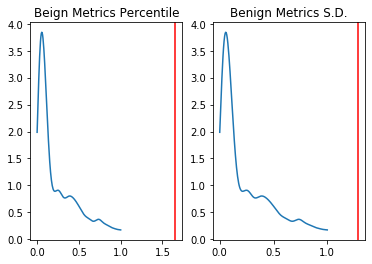

0.13570499420166016 seconds


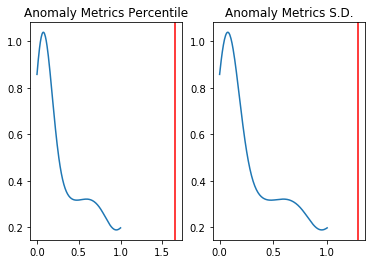

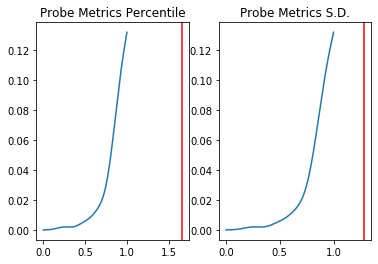

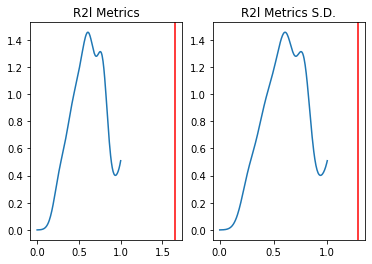

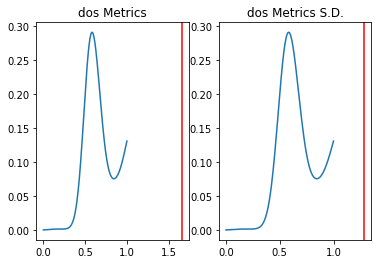

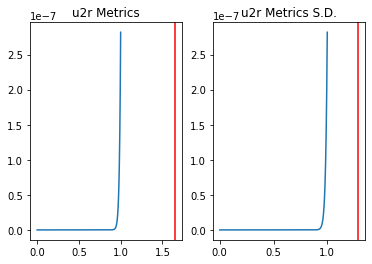

In [28]:

#set limits

benign_metrics = anomaly_detector.evaluate(data_benign_new) #this
alpha = 3
sd_benign = np.std(benign_metrics)
mean_benign = np.mean(benign_metrics)
lim_benign = mean_benign + alpha * sd_benign 
pct_benign = np.percentile(benign_metrics, 99.7) 


#visualizing benign
density = gaussian_kde(benign_metrics)
plt.subplot(121)
plt.axvline(x=pct_benign, color='red')
xs = np.linspace(0,1,200)
plt.plot(xs,density(xs))
plt.title("Beign Metrics Percentile")
plt.subplot(122)
plt.axvline(x=lim_benign, color='red')
xs= np.linspace(0,1,200)
plt.plot(xs,density(xs))
plt.title("Benign Metrics S.D.")
plt.show()          


#visualizing all anomalies

start_timeprint = time.time()
anomaly_metrics = anomaly_detector.evaluate(evaluation) #this
elapsed_time = time.time() - start_timeprint
print(elapsed_time, "seconds")


density = gaussian_kde(anomaly_metrics)
plt.subplot(121)
plt.axvline(x=pct_benign, color='red')
xs = np.linspace(0,1,200)
plt.plot(xs,density(xs))
plt.title("Anomaly Metrics Percentile")
plt.subplot(122)
plt.axvline(x=lim_benign, color='red')
xs = np.linspace(0,1,200)
plt.plot(xs,density(xs))
plt.title("Anomaly Metrics S.D.")
plt.show()

#visualizing each anomaly
probe_metrics = anomaly_detector.evaluate(dft_data_probe_new) #this

density = gaussian_kde(probe_metrics)
plt.subplot(121)
plt.axvline(x=pct_benign, color='red')
xs = np.linspace(0,1,200)
plt.plot(xs,density(xs))
plt.title("Probe Metrics Percentile")
plt.subplot(122)
plt.axvline(x=lim_benign, color='red')
xs = np.linspace(0,1,200)
plt.plot(xs,density(xs))
plt.title("Probe Metrics S.D.")
plt.show()


r2l_metrics = anomaly_detector.evaluate(dft_data_r2l_new) #this

density = gaussian_kde(r2l_metrics)
plt.subplot(121)
plt.axvline(x=pct_benign, color='red')
xs = np.linspace(0,1,200)
plt.plot(xs,density(xs))
plt.title("R2l Metrics")
plt.subplot(122)
plt.axvline(x=lim_benign, color='red')
xs = np.linspace(0,1,200)
plt.plot(xs,density(xs))
plt.title("R2l Metrics S.D.")
plt.show()

dos_metrics = anomaly_detector.evaluate(dft_data_dos_new) #this

density = gaussian_kde(dos_metrics)
plt.subplot(121)
plt.axvline(x=pct_benign, color='red')
xs = np.linspace(0,1,200)
plt.plot(xs,density(xs))
plt.title("dos Metrics")
plt.subplot(122)
plt.axvline(x=lim_benign, color='red')
xs = np.linspace(0,1,200)
plt.plot(xs,density(xs))
plt.title("dos Metrics S.D.")
plt.show()

u2r_metrics = anomaly_detector.evaluate(dft_data_u2r_new) #this

density = gaussian_kde(u2r_metrics)
plt.subplot(121)
plt.axvline(x=pct_benign, color='red')
xs = np.linspace(0,1,200)
plt.plot(xs,density(xs))
plt.title("u2r Metrics")
plt.subplot(122)
plt.axvline(x=lim_benign, color='red')
xs = np.linspace(0,1,200)
plt.plot(xs,density(xs))
plt.title("u2r Metrics S.D.")
plt.show()

In [29]:

metrics = [benign_metrics, anomaly_metrics, probe_metrics, r2l_metrics, dos_metrics, u2r_metrics]
metric_names = ["benign", "all anomalies", "probe", "r2l", "dos", "u2r"]
alpha = 3
for metric, name in zip(metrics, metric_names):
    print(name)
    get_anomalies(benign_metrics, metric, alpha, False)
    

benign
Determined:  1.7151003073816136 % as anomaly
all anomalies
Determined:  39.7444996451384 % as anomaly
probe
Determined:  90.12804626187526 % as anomaly
r2l
Determined:  5.407279029462738 % as anomaly
dos
Determined:  85.69705093833781 % as anomaly
u2r
Determined:  100.0 % as anomaly
